## Stateful RNNs

**Stateful**: means that the RNNs can maintain state across batches during training and even maintain that state when doing predictions.

**In practice it is** the hidden state computed for a batch of training data will be used as the initial hidden state for the next batch of training data. 

**Advantages**: results in smaller network sizes and/or lower training times. 

**Disvantage**: we are now responsible for training the network with a batch size that reflects the
periodicity of the data, and resetting the state after each epoch. In addition, data should not be shuffled
while training the network, since the order in which the data is presented is relevant for stateful
networks.

**Problem: Predict Electricity Consumption**

As you will recall, RNNs in Keras are stateless by default.

In **Stateful models**, the internal states computed after processing a batch of input is
reused as initial states for the next batch. In other words, the state computed from element i in a batch
will be used as initial state for the element i in the next batch.

One thing to remember is that most problems can be solved with stateless RNNs, so if you do use a
stateful RNN, make sure you need it. Typically, you would need a **Stateful RNN when the data has a periodic
component.**


**Dataset**

The dataset we will use is the electricity load diagram dataset from the UCI Machine Learning
Repository (https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014), and contains consumption
information about 370 customers, taken at 15 minute intervals over a four year period from 2011 to 2014. We randomly choose customer number 250 for our example.

Let us extract the consumption data for customer
number 250 and plot the first 10 days of data. Finally we also save it to a binary NumPy file for our
next step:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re

100 lines read
200 lines read
300 lines read
400 lines read
500 lines read
600 lines read
700 lines read
800 lines read
900 lines read
1000 lines read
1100 lines read
1200 lines read
1300 lines read
1400 lines read
1500 lines read
1600 lines read
1700 lines read
1800 lines read
1900 lines read
2000 lines read
2100 lines read
2200 lines read
2300 lines read
2400 lines read
2500 lines read
2600 lines read
2700 lines read
2800 lines read
2900 lines read
3000 lines read
3100 lines read
3200 lines read
3300 lines read
3400 lines read
3500 lines read
3600 lines read
3700 lines read
3800 lines read
3900 lines read
4000 lines read
4100 lines read
4200 lines read
4300 lines read
4400 lines read
4500 lines read
4600 lines read
4700 lines read
4800 lines read
4900 lines read
5000 lines read
5100 lines read
5200 lines read
5300 lines read
5400 lines read
5500 lines read
5600 lines read
5700 lines read
5800 lines read
5900 lines read
6000 lines read
6100 lines read
6200 lines read
6300 lines read
6

49000 lines read
49100 lines read
49200 lines read
49300 lines read
49400 lines read
49500 lines read
49600 lines read
49700 lines read
49800 lines read
49900 lines read
50000 lines read
50100 lines read
50200 lines read
50300 lines read
50400 lines read
50500 lines read
50600 lines read
50700 lines read
50800 lines read
50900 lines read
51000 lines read
51100 lines read
51200 lines read
51300 lines read
51400 lines read
51500 lines read
51600 lines read
51700 lines read
51800 lines read
51900 lines read
52000 lines read
52100 lines read
52200 lines read
52300 lines read
52400 lines read
52500 lines read
52600 lines read
52700 lines read
52800 lines read
52900 lines read
53000 lines read
53100 lines read
53200 lines read
53300 lines read
53400 lines read
53500 lines read
53600 lines read
53700 lines read
53800 lines read
53900 lines read
54000 lines read
54100 lines read
54200 lines read
54300 lines read
54400 lines read
54500 lines read
54600 lines read
54700 lines read
54800 lines re

97300 lines read
97400 lines read
97500 lines read
97600 lines read
97700 lines read
97800 lines read
97900 lines read
98000 lines read
98100 lines read
98200 lines read
98300 lines read
98400 lines read
98500 lines read
98600 lines read
98700 lines read
98800 lines read
98900 lines read
99000 lines read
99100 lines read
99200 lines read
99300 lines read
99400 lines read
99500 lines read
99600 lines read
99700 lines read
99800 lines read
99900 lines read
100000 lines read
100100 lines read
100200 lines read
100300 lines read
100400 lines read
100500 lines read
100600 lines read
100700 lines read
100800 lines read
100900 lines read
101000 lines read
101100 lines read
101200 lines read
101300 lines read
101400 lines read
101500 lines read
101600 lines read
101700 lines read
101800 lines read
101900 lines read
102000 lines read
102100 lines read
102200 lines read
102300 lines read
102400 lines read
102500 lines read
102600 lines read
102700 lines read
102800 lines read
102900 lines read
1

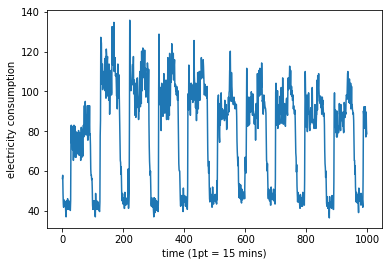

In [5]:
DATA_DIR = "data"

with open(os.path.join(DATA_DIR, "LD2011_2014.txt"), "r") as fld:
    data = []
    cid = 250
    for line_num, line in enumerate(fld):
        if line.startswith("\"\";"):
            continue
        if line_num % 100 == 0:
            print("{:d} lines read".format(line_num))
        cols = [float(re.sub(",", ".", x)) for x in
                line.strip().split(";")[1:]]
        data.append(cols[cid])

NUM_ENTRIES = 1000
plt.plot(range(NUM_ENTRIES), data[0:NUM_ENTRIES])
plt.ylabel("electricity consumption")
plt.xlabel("time (1pt = 15 mins)")
plt.show()

np.save(os.path.join(DATA_DIR, "LD_250.npy"), np.array(data))

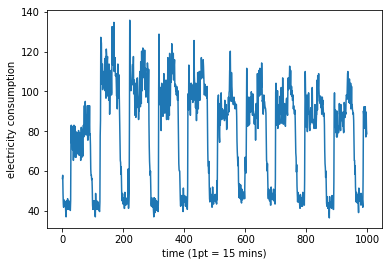

In [6]:
NUM_ENTRIES = 1000
plt.plot(range(NUM_ENTRIES), data[0:NUM_ENTRIES])
plt.ylabel("electricity consumption")
plt.xlabel("time (1pt = 15 mins)")
plt.show()

np.save(os.path.join(DATA_DIR, "LD_250.npy"), np.array(data))

As you can see, there is clearly a daily periodic trend. So the problem is a good candidate for a
stateful model. Also, based on our observation, a BATCH_SIZE of 96 (number of 15 minute readings over
24 hours) seems appropriate.

Most of the code is identical for both versions (stateless / stateful) , so we will look at both versions
simultaneously. 

The differences will be pointed out in the code as they arise

In [8]:
import numpy as np
from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import math
#import os

**read data from file**

In [ ]:
DATA_DIR = "./data"

data = np.load(os.path.join(DATA_DIR, "LD_250.npy"))

In [ ]:
STATELESS = True

NUM_TIMESTEPS = 20
HIDDEN_SIZE = 10
BATCH_SIZE = 96  # 24 hours (15 min intervals)
NUM_EPOCHS = 5

**Rescale the binary file to the range(0,1)**

In [ ]:
# scale the data to be in the range (0, 1)
data = data.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
data = scaler.fit_transform(data)

Based on some experimentation, we get a value of NUM_TIMESTEPS as 20, that is, each input row will be a sequence of
length 20, and the output will have length 1. The next step rearranges the input array into X and Y tensors
of shapes (None, 4) and (None, 1). Finally, we reshape the input tensor X to three dimensions as required
by the network.

In [ ]:
# transform to 4 inputs -> 1 label format
X = np.zeros((data.shape[0], NUM_TIMESTEPS))                  # each input row will be a sequence of length 20
Y = np.zeros((data.shape[0], 1))                              # the output will have length 1
for i in range(len(data) - NUM_TIMESTEPS - 1):
    X[i] = data[i:i + NUM_TIMESTEPS].T
    Y[i] = data[i + NUM_TIMESTEPS + 1]

# reshape X to three dimensions (samples, timesteps, features)
X = np.expand_dims(X, axis=2)

We then split our X and Y tensors into a 70-30 training test split. Since we are working with time
series, we just choose a split point and cut the data into two parts, rather than using the train_test_split
function, which also shuffles the data:

In [ ]:
# split into training and test sets (add the extra offsets so
# we can use batch size of 5)
sp = int(0.7 * len(data))
Xtrain, Xtest, Ytrain, Ytest = X[0:sp], X[sp:], Y[0:sp], Y[sp:]
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

In [9]:

if STATELESS:
    # stateless
    model = Sequential()
    model.add(LSTM(HIDDEN_SIZE, input_shape=(NUM_TIMESTEPS, 1),
                   return_sequences=False))
    model.add(Dense(1))
else:
    # stateful
    model = Sequential()
    model.add(LSTM(HIDDEN_SIZE, stateful=True,
                   batch_input_shape=(BATCH_SIZE, NUM_TIMESTEPS, 1),
                   return_sequences=False))
    model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam",
              metrics=["mean_squared_error"])

if STATELESS:
    # stateless
    model.fit(Xtrain, Ytrain, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
              validation_data=(Xtest, Ytest),
              shuffle=False)
else:
    # stateful
    # need to make training and test data to multiple of BATCH_SIZE
    train_size = (Xtrain.shape[0] // BATCH_SIZE) * BATCH_SIZE
    test_size = (Xtest.shape[0] // BATCH_SIZE) * BATCH_SIZE
    Xtrain, Ytrain = Xtrain[0:train_size], Ytrain[0:train_size]
    Xtest, Ytest = Xtest[0:test_size], Ytest[0:test_size]
    print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)
    for i in range(NUM_EPOCHS):
        print("Epoch {:d}/{:d}".format(i+1, NUM_EPOCHS))
        model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE, epochs=1,
                  validation_data=(Xtest, Ytest),
                  shuffle=False)
        model.reset_states()

score, _ = model.evaluate(Xtest, Ytest, batch_size=BATCH_SIZE)
rmse = math.sqrt(score)
print("\nMSE: {:.3f}, RMSE: {:.3f}".format(score, rmse))

(98179, 20, 1) (42077, 20, 1) (98179, 1) (42077, 1)
Train on 98179 samples, validate on 42077 samples
Epoch 1/5
98179/98179 [==============================] - 16s 164us/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 2/5
98179/98179 [==============================] - 12s 124us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 3/5
98179/98179 [==============================] - 12s 122us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 4/5
98179/98179 [==============================] - 12s 121us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 5/5
42077/42077 [==============================] - 1s 17us/step

MSE: 0.004, RMSE: 0.061


**Additional notes:**

Stateful model

There are three things to be aware of here:

- 1: We should select a batch size that reflects the periodicity of your data. This is because stateful RNNs align the states from each batch to the next, so selecting the right batch size allows the network to learn faster. Once you set the batch size, the size of your training and test sets needs to be exact multiples of your batch size. We have ensured this below by truncating the last few records from both our training and test sets.
- 2: We need to fit the model manually, training the model in a loop for the required number of epochs. Each iteration trains the model for one epoch, and the state is retained across multiple batches. After each epoch, the state of the model needs to be reset manually.
- 3: The data should be fed in sequence. By default, Keras will shuffle the rows within each batch, which will destroy the alignment we need for the stateful RNN to learn effectively. This is done by setting shuffle=False in the call to model.fit()